In [304]:
import os
import math
import sys
import statsmodels.api as sm
import numpy as np
import seaborn as sns
import re
from functools import reduce
from operator import and_
import yfinance as yf
from statsmodels.stats.outliers_influence import variance_inflation_factor 
import datetime as dt
from pdb import set_trace as keyboard
import xlrd
from xlrd import open_workbook
from sklearn.decomposition import FastICA
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data as pdr
from tkinter import StringVar
import matplotlib.pyplot as plt
from sklearn import linear_model
clf = linear_model.LinearRegression()

import matplotlib

yf.pdr_override()

In [305]:
nDays = 50
endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days=nDays)

In [306]:
cotacoesDF = pd.read_csv('assets/cotacoes.txt')
cotacoesDF.iloc[0,0].split(' ')[0]

[***************       32%                       ]  95 of 297 downloaded

'012019080102AALR3'

[***************       32%                       ]  96 of 297 downloaded

In [307]:
stocksInExchange_raw = pd.DataFrame({})
subString = cotacoesDF.iloc[:,0].apply(lambda x: x.split(' ')[0])
stocksInExchange_raw['date'] = subString.apply(lambda x: x[:12])
stocksInExchange_raw['ticker'] = subString.apply(lambda x: x[12:])

firstDate = stocksInExchange_raw['date'][0]
firstDate

[****************      33%                       ]  97 of 297 downloaded

'012019080102'

In [308]:
def condition(x):
    cond =  (not 'F' in x) & \
            (not '32' in x) & \
            (not '33' in x) & \
            (not '34' in x) & \
            (not '35' in x) 
    if not '11' in x:
        cond = cond & (len(x) <= 5)
    return cond

In [309]:
stocksInExchange = stocksInExchange_raw[stocksInExchange_raw['date'] == firstDate]['ticker'].to_frame()
stocksInExchange['company'] = stocksInExchange['ticker'].apply(lambda x: x[:4])
stockExchange_Mask = stocksInExchange['ticker'].apply(condition)
stocksInExchange = stocksInExchange[stockExchange_Mask]
stocksInExchange.sample(40)['ticker'].values

[****************      33%                       ]  99 of 297 downloaded

array(['AGRO3', 'BKBR3', 'BRDT3', 'PNVL3', 'CGRA4', 'RSID3', 'BBDC4',
       'MNDL3', 'LREN3', 'LAME3', 'CEEB3', 'BPAN4', 'EZTC3', 'TIET4',
       'BNBR3', 'BMEB3', 'ENGI11', 'COCE5', 'ENGI4', 'CTSA3', 'SBSP3',
       'TOYB4', 'MULT3', 'GOAU3', 'LIQO3', 'ALPA3', 'LOGN3', 'TIMP3',
       'MOVI3', 'CPRE3', 'SSBR3', 'RNEW4', 'CSRN6', 'ELET6', 'USIM3',
       'NEOE3', 'TEND3', 'CTSA4', 'UCAS3', 'ITUB3'], dtype=object)

In [310]:
"""
stocksInExchange2 = stocksInExchange.loc[stocksInExchange['company'].duplicated(), :]
stocksInExchange.drop_duplicates('company', inplace=True)
print(stocksInExchange.sample(10))
print('\n')
print(stocksInExchange2.sample(10))
"""

"\nstocksInExchange2 = stocksInExchange.loc[stocksInExchange['company'].duplicated(), :]\nstocksInExchange.drop_duplicates('company', inplace=True)\nprint(stocksInExchange.sample(10))\nprint('\n')\nprint(stocksInExchange2.sample(10))\n"

In [311]:
fund_data_raw = pd.read_excel('assets/12239939000192.xlsx')

[*****************     35%                       ]  103 of 297 downloaded

In [312]:
mask = (fund_data_raw['Data'] > startDate) & (fund_data_raw['Data'] <= endDate)
fund_data = fund_data_raw[mask]
fund_data.set_index('Data', inplace=True)
fund_pctChange = pd.DataFrame(fund_data['Variação'])

In [313]:
ibov_data = pd.read_csv('assets/ibov.csv', sep=';')
#tickers = ibov_data.iloc[:,0].values[:-2]
tickers = stocksInExchange['ticker'].tolist()

In [314]:
tickers_yf = [ticker + '.SA' for ticker in tickers]

startDate_str = startDate.strftime("%Y-%m-%d")
endDate_str   = endDate.strftime("%Y-%m-%d")
stocks_df_raw = pdr.get_data_yahoo(tickers_yf, start=startDate_str, end=endDate_str)['Close']

[*********************100%***********************]  297 of 297 downloaded
[*********************103%************************]  307 of 297 downloaded

In [315]:
stocks_df = stocks_df_raw.pct_change()
stocks_df.columns = [i.replace('.SA', '') for i in stocks_df.columns]
stocks_df.head()

[**********************104%************************]  308 of 297 downloaded

,AALR3,ABCB4,ABEV3,ADHM3,AGRO3,ALPA3,ALPA4,ALSC3,ALUP11,ALUP3,...,VIVT4,VLID3,VULC3,VVAR3,WEGE3,WHRL3,WHRL4,WIZS3,WLMM4,YDUQ3
Date,,,,,,,,,,,,,,,,,,,,,
2019-07-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-07-16,-0.012266,0.002205,-0.008219,-0.012987,0.011838,0.006876,-0.001406,0.003262,NaN,-0.011111,...,0.008194,0.013003,0.002874,0.014225,0.004911,-0.017857,-0.001770,0.015900,0.002604,NaN
2019-07-17,0.000000,-0.001100,-0.006077,0.013158,0.004926,-0.009756,0.024413,0.017702,NaN,0.074157,...,-0.002586,0.006724,0.025788,0.025245,0.000888,-0.014545,0.026596,-0.012356,-0.006494,NaN
2019-07-18,0.000000,0.013216,0.014452,0.025974,-0.001838,-0.004433,0.001375,-0.007810,NaN,-0.001046,...,-0.005741,-0.011536,0.041899,0.009576,0.009765,-0.029520,-0.027634,0.030025,0.000000,NaN
2019-07-19,-0.003268,-0.005978,-0.008767,-0.037975,0.007366,0.004948,-0.007323,-0.008945,NaN,-0.017801,...,0.001118,-0.001843,-0.014745,-0.031165,0.001758,-0.032319,-0.021314,0.013765,0.000000,NaN


[**********************104%************************]  309 of 297 downloaded

In [316]:
#stocks_df.columns

In [317]:
data = fund_pctChange.join(stocks_df)
data.fillna(data.mean(), inplace=True)
columns_with_problem = data.columns.to_series()[np.isnan(data).any()]
data.drop(columns_with_problem, axis=1, inplace=True)

[**********************105%************************]  312 of 297 downloaded

In [318]:
y = data.iloc[:,0]
X_total = data.iloc[:, 1:]
len(X_total)

32

In [319]:
class Results:
    def __init__(self, model, rsquared_adj, pvalues, selected_stocks):
        self.model = model
        self.rsquared_adj = rsquared_adj
        self.pvalues = pvalues
        self.selected_stocks = selected_stocks

In [320]:
#columns_with_problem = X_total.columns.to_series()[np.isnan(X_total).any()]
#X_total.drop(columns_with_problem, axis=1, inplace=True)

In [321]:
nCols = X_total.columns.size
nCols

286

Iteration number 99999***************164%***************************************]  488 of 297 downloadedNumber of stocks: 17

Stocks: ['LOGN3', 'BPAN4', 'BEES4', 'ENEV3', 'ALUP4', 'VIVT4', 'QUAL3', 'CESP6', 'UNIP3', 'EALT4', 'ARZZ3', 'CESP3', 'BTTL3', 'EMAE4', 'CIEL3', 'EUCA4', 'PRIO3']

R2 adj: 0.9836346332524722

p-values:                   0
LOGN3  2.754743e-06
BPAN4  1.094855e-02
BEES4  4.425477e-03
ENEV3  1.515120e-02
ALUP4  1.910699e-03
VIVT4  8.141455e-06
QUAL3  2.962566e-03
CESP6  1.100351e-03
UNIP3  2.329945e-08
EALT4  1.026970e-06
ARZZ3  9.772508e-03
CESP3  4.342508e-03
BTTL3  1.547724e-04
EMAE4  5.098418e-04
CIEL3  3.371212e-04
EUCA4  2.128121e-04
PRIO3  2.372785e-08

Params:                                  OLS Regression Results                                
Dep. Variable:               Variação   R-squared (uncentered):                   0.992
Model:                            OLS   Adj. R-squared (uncentered):              0.984
Method:                 Least Squares   

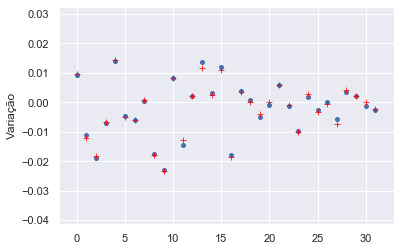

In [322]:
predef_stocks = []
stocks_to_sample = [x for x in X_total.columns if not x in predef_stocks]

# Def array stocks to remove from analysis
# Remover small caps pouco líquidas e açoes com pouca mov. diária

from pdb import set_trace as keyboard

N = 100000
minNumberStocks = 12
sensitivity = .10
size_samples = np.random.randint(12-len(predef_stocks), 20-len(predef_stocks), size=N)

result_list = []
rsquared_ajd_list = []

X_total_model = X_total.copy()
X_total_model['Bias'] = 1.

useBias = 0

for iteration in range(N):
    
    sys.stdout.write("\rIteration number {}".format(iteration))
    sys.stdout.flush()
    
    while True:
        
        selected_stocks = np.random.choice(stocks_to_sample, size=size_samples[iteration]).tolist() + \
                                                                    predef_stocks
        if useBias:
             selected_stocks += ['Bias']

        X = X_total_model[selected_stocks]

        regressor_OLS = sm.OLS(endog=y, exog=X.values).fit()  
        pvalues_dict = dict(zip(selected_stocks, regressor_OLS.pvalues))

        try:
        
            while max(list(pvalues_dict.values())) > sensitivity:
                stocks_bigPvalue = list({ key:value for (key,value) in pvalues_dict.items() if value > sensitivity}.keys())
                if 'Bias' in stocks_bigPvalue:
                    stocks_bigPvalue.remove('Bias')
                stockToRemove = np.random.choice(stocks_bigPvalue)
                selected_stocks.remove(stockToRemove)
                #stocks_bigPvalue.remove(stockToRemove)
                del X[stockToRemove]
                regressor_OLS = sm.OLS(endog=y, exog=X.values).fit()  
                pvalues_dict = dict(zip(selected_stocks, regressor_OLS.pvalues))
                if len(pvalues_dict) == minNumberStocks:
                    break

            result_list.append(Results(regressor_OLS,
                               regressor_OLS.rsquared_adj, 
                               pvalues_dict, 
                               selected_stocks))
        
        except:
            pass
        
        if len(pvalues_dict) > 0:
            break
                          


    
from operator import attrgetter
best_rsquaredAdj_obj = max(result_list, key=attrgetter('rsquared_adj'))

print('Number of stocks: %s' % len(best_rsquaredAdj_obj.selected_stocks))
print('\nStocks: %s' % best_rsquaredAdj_obj.selected_stocks)
print('\nR2 adj: %s' % best_rsquaredAdj_obj.rsquared_adj)
print('\np-values: %s' % pd.DataFrame(best_rsquaredAdj_obj.pvalues.values(), list(best_rsquaredAdj_obj.pvalues.keys())))
print('\nParams: %s' % best_rsquaredAdj_obj.model.summary(xname=best_rsquaredAdj_obj.selected_stocks))

fig, ax = plt.subplots()
fittedValues = X_total_model[best_rsquaredAdj_obj.selected_stocks].multiply(best_rsquaredAdj_obj.model.params.values).sum(axis=1).values
sns.scatterplot(range(len(y)), y, ax=ax)
sns.scatterplot(range(len(fittedValues)), fittedValues, marker='+', color='red', ax=ax)

In [323]:
list(best_rsquaredAdj_obj.pvalues.keys())

['LOGN3',
 'BPAN4',
 'BEES4',
 'ENEV3',
 'ALUP4',
 'VIVT4',
 'QUAL3',
 'CESP6',
 'UNIP3',
 'EALT4',
 'ARZZ3',
 'CESP3',
 'BTTL3',
 'EMAE4',
 'CIEL3',
 'EUCA4',
 'PRIO3']

In [324]:
selected_stocks.remove('CCRO3')

ValueError: list.remove(x): x not in list